# 13.2a: bfloat16 Bit-Level Analysis of Dead Tokens

**Goal:** Analyze the raw bfloat16 bit patterns of dead token embeddings to understand the hypercube structure.

## Background

Previous analysis (12.4e) showed that 85% of dimensions vary by exactly 1 ULP across the 124 unique dead token vectors. This suggests discrete lattice structure at the bfloat16 quantization level.

bfloat16 format:
- 16 bits total: 1 sign + 8 exponent + 7 mantissa
- We'll reinterpret as int16 to see raw bit patterns
- Identify which dimensions are constant vs varying
- Analyze bit-level differences

## Method

1. Load dead token embeddings in bfloat16
2. Reinterpret as int16 (raw bits)
3. For each dimension, find unique bit patterns
4. Identify constant dimensions (1 unique pattern)
5. Analyze varying dimensions (>1 unique pattern)
6. Visualize bit-level structure

## Parameters

In [1]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Figure settings
DPI = 150
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Dead Token Embeddings

In [3]:
print("Loading dead token embeddings...\n")

data = load_file(DEAD_TOKENS_PATH)

# Load bfloat16 embeddings
dead_embeddings_bf16 = data['dead_embeddings_bfloat16']
dead_embeddings_f32 = data['dead_embeddings_float32']

print(f"✓ Loaded dead token embeddings")
print(f"  Shape: {dead_embeddings_bf16.shape}")
print(f"  bfloat16 dtype: {dead_embeddings_bf16.dtype}")
print(f"  float32 dtype: {dead_embeddings_f32.dtype}")

n_dead, n_dims = dead_embeddings_bf16.shape

# Get unique vectors for analysis
unique_vectors_f32, inverse, counts = torch.unique(
    dead_embeddings_f32, dim=0, return_inverse=True, return_counts=True
)
n_unique = len(unique_vectors_f32)

print(f"\n  Total dead tokens: {n_dead:,}")
print(f"  Unique vectors: {n_unique}")

Loading dead token embeddings...

✓ Loaded dead token embeddings
  Shape: torch.Size([2221, 2560])
  bfloat16 dtype: torch.bfloat16
  float32 dtype: torch.float32

  Total dead tokens: 2,221
  Unique vectors: 134


## Extract Unique Vectors in bfloat16

We need to extract the unique vectors while staying in bfloat16 representation.

In [4]:
print("\nExtracting unique vectors in bfloat16...\n")

# Use the inverse indices from float32 unique to extract bfloat16 versions
# For each unique vector, find one representative token
unique_indices = []
for i in range(n_unique):
    # Find first token with this unique vector
    first_idx = (inverse == i).nonzero()[0].item()
    unique_indices.append(first_idx)

unique_vectors_bf16 = dead_embeddings_bf16[unique_indices]

print(f"✓ Extracted {len(unique_vectors_bf16)} unique vectors in bfloat16")
print(f"  Shape: {unique_vectors_bf16.shape}")


Extracting unique vectors in bfloat16...

✓ Extracted 134 unique vectors in bfloat16
  Shape: torch.Size([134, 2560])


## Reinterpret as Raw Bits (int16)

In [5]:
print("\nReinterpreting as raw bits...\n")

# Reinterpret bfloat16 as int16 to see raw bit patterns
unique_as_bits = unique_vectors_bf16.view(torch.int16)

print(f"✓ Reinterpreted as int16")
print(f"  Shape: {unique_as_bits.shape}")
print(f"  Dtype: {unique_as_bits.dtype}")

# Show first few values
print(f"\nFirst unique vector (first 10 dimensions):")
print(f"  bfloat16 values: {unique_vectors_bf16[0, :10].tolist()}")
print(f"  int16 bits: {unique_as_bits[0, :10].tolist()}")


Reinterpreting as raw bits...

✓ Reinterpreted as int16
  Shape: torch.Size([134, 2560])
  Dtype: torch.int16

First unique vector (first 10 dimensions):
  bfloat16 values: [0.005859375, 0.01324462890625, 0.01202392578125, 0.03662109375, 0.0157470703125, -0.01239013671875, 0.00640869140625, 0.00811767578125, -0.0213623046875, -0.052001953125]
  int16 bits: [15296, 15449, 15429, 15638, 15489, -17333, 15314, 15365, -17233, -17067]


## Analyze Per-Dimension Bit Patterns

In [6]:
print("\nAnalyzing per-dimension bit patterns...\n")

# For each dimension, count unique bit patterns
n_unique_patterns = torch.zeros(n_dims, dtype=torch.int64)

for dim in range(n_dims):
    values_in_dim = unique_as_bits[:, dim]
    unique_patterns = torch.unique(values_in_dim)
    n_unique_patterns[dim] = len(unique_patterns)

# Classify dimensions
constant_dims = (n_unique_patterns == 1)
varying_dims = (n_unique_patterns > 1)

n_constant = constant_dims.sum().item()
n_varying = varying_dims.sum().item()

print(f"✓ Analyzed {n_dims} dimensions")
print(f"\nClassification:")
print(f"  Constant dimensions (1 unique pattern): {n_constant} ({n_constant/n_dims*100:.1f}%)")
print(f"  Varying dimensions (>1 unique pattern): {n_varying} ({n_varying/n_dims*100:.1f}%)")

# Distribution of unique patterns
print(f"\nDistribution of unique patterns per dimension:")
for n_pat in range(1, n_unique_patterns.max().item() + 1):
    n_dims_with_pat = (n_unique_patterns == n_pat).sum().item()
    if n_dims_with_pat > 0:
        print(f"  {n_pat} unique pattern(s): {n_dims_with_pat} dimensions")


Analyzing per-dimension bit patterns...

✓ Analyzed 2560 dimensions

Classification:
  Constant dimensions (1 unique pattern): 0 (0.0%)
  Varying dimensions (>1 unique pattern): 2560 (100.0%)

Distribution of unique patterns per dimension:
  2 unique pattern(s): 6 dimensions
  3 unique pattern(s): 23 dimensions
  4 unique pattern(s): 53 dimensions
  5 unique pattern(s): 103 dimensions
  6 unique pattern(s): 138 dimensions
  7 unique pattern(s): 200 dimensions
  8 unique pattern(s): 284 dimensions
  9 unique pattern(s): 325 dimensions
  10 unique pattern(s): 334 dimensions
  11 unique pattern(s): 254 dimensions
  12 unique pattern(s): 134 dimensions
  13 unique pattern(s): 106 dimensions
  14 unique pattern(s): 115 dimensions
  15 unique pattern(s): 71 dimensions
  16 unique pattern(s): 56 dimensions
  17 unique pattern(s): 51 dimensions
  18 unique pattern(s): 61 dimensions
  19 unique pattern(s): 45 dimensions
  20 unique pattern(s): 15 dimensions
  21 unique pattern(s): 14 dimension

## Examine Varying Dimensions

Focus on dimensions that actually vary across unique vectors.

In [7]:
print("\nExamining varying dimensions...\n")

varying_dim_indices = torch.where(varying_dims)[0]

print(f"First 20 varying dimensions:")
print(f"{'Dim':>6} {'N patterns':>12} {'Example patterns (int16)':>40}")
print("-" * 70)

for i in range(min(20, len(varying_dim_indices))):
    dim_idx = varying_dim_indices[i].item()
    values_in_dim = unique_as_bits[:, dim_idx]
    unique_patterns = torch.unique(values_in_dim)
    
    # Show first 3 patterns
    example_patterns = unique_patterns[:3].tolist()
    pattern_str = str(example_patterns)
    if len(unique_patterns) > 3:
        pattern_str += " ..."
    
    print(f"{dim_idx:>6} {len(unique_patterns):>12} {pattern_str:>40}")


Examining varying dimensions...

First 20 varying dimensions:
   Dim   N patterns                 Example patterns (int16)
----------------------------------------------------------------------
     0            9                [15296, 15300, 15302] ...
     1            5                [15446, 15447, 15449] ...
     2            6                [15422, 15423, 15424] ...
     3            4                [15636, 15637, 15638] ...
     4            5                [15488, 15489, 15490] ...
     5            5             [-17333, -17331, -17330] ...
     6            9                [15314, 15315, 15317] ...
     7            5                [15365, 15367, 15368] ...
     8            5             [-17234, -17233, -17232] ...
     9            4             [-17068, -17067, -17066] ...
    10            7                [15387, 15388, 15389] ...
    11           11                [15092, 15093, 15099] ...
    12            4             [-17270, -17268, -17266] ...
    13      

## Analyze Bit-Level Differences

For varying dimensions, compute the range of bit patterns (max - min).

In [8]:
print("\nAnalyzing bit-level differences...\n")

# For each dimension, compute range of bit patterns
bit_ranges = torch.zeros(n_dims, dtype=torch.int32)

for dim in range(n_dims):
    values_in_dim = unique_as_bits[:, dim]
    min_val = values_in_dim.min().item()
    max_val = values_in_dim.max().item()
    bit_ranges[dim] = max_val - min_val

# Statistics on varying dimensions only
varying_ranges = bit_ranges[varying_dims]

print(f"Bit range statistics (varying dimensions only):")
print(f"  Min range: {varying_ranges.min().item()}")
print(f"  Max range: {varying_ranges.max().item()}")
print(f"  Mean range: {varying_ranges.float().mean().item():.2f}")
print(f"  Median range: {varying_ranges.float().median().item():.0f}")

# Count dimensions by range
print(f"\nDimensions by bit range:")
for r in torch.unique(varying_ranges).tolist():
    n_dims_with_range = (varying_ranges == r).sum().item()
    print(f"  Range = {r}: {n_dims_with_range} dimensions")


Analyzing bit-level differences...

Bit range statistics (varying dimensions only):
  Min range: 1
  Max range: 34202
  Mean range: 1050.50
  Median range: 21

Dimensions by bit range:
  Range = 1: 5 dimensions
  Range = 2: 17 dimensions
  Range = 3: 24 dimensions
  Range = 4: 39 dimensions
  Range = 5: 54 dimensions
  Range = 6: 79 dimensions
  Range = 7: 78 dimensions
  Range = 8: 76 dimensions
  Range = 9: 63 dimensions
  Range = 10: 64 dimensions
  Range = 11: 87 dimensions
  Range = 12: 121 dimensions
  Range = 13: 109 dimensions
  Range = 14: 107 dimensions
  Range = 15: 94 dimensions
  Range = 16: 67 dimensions
  Range = 17: 53 dimensions
  Range = 18: 36 dimensions
  Range = 19: 38 dimensions
  Range = 20: 43 dimensions
  Range = 21: 44 dimensions
  Range = 22: 29 dimensions
  Range = 23: 38 dimensions
  Range = 24: 67 dimensions
  Range = 25: 40 dimensions
  Range = 26: 54 dimensions
  Range = 27: 29 dimensions
  Range = 28: 44 dimensions
  Range = 29: 36 dimensions
  Range =

## Figure 1: Per-Dimension Pattern Count

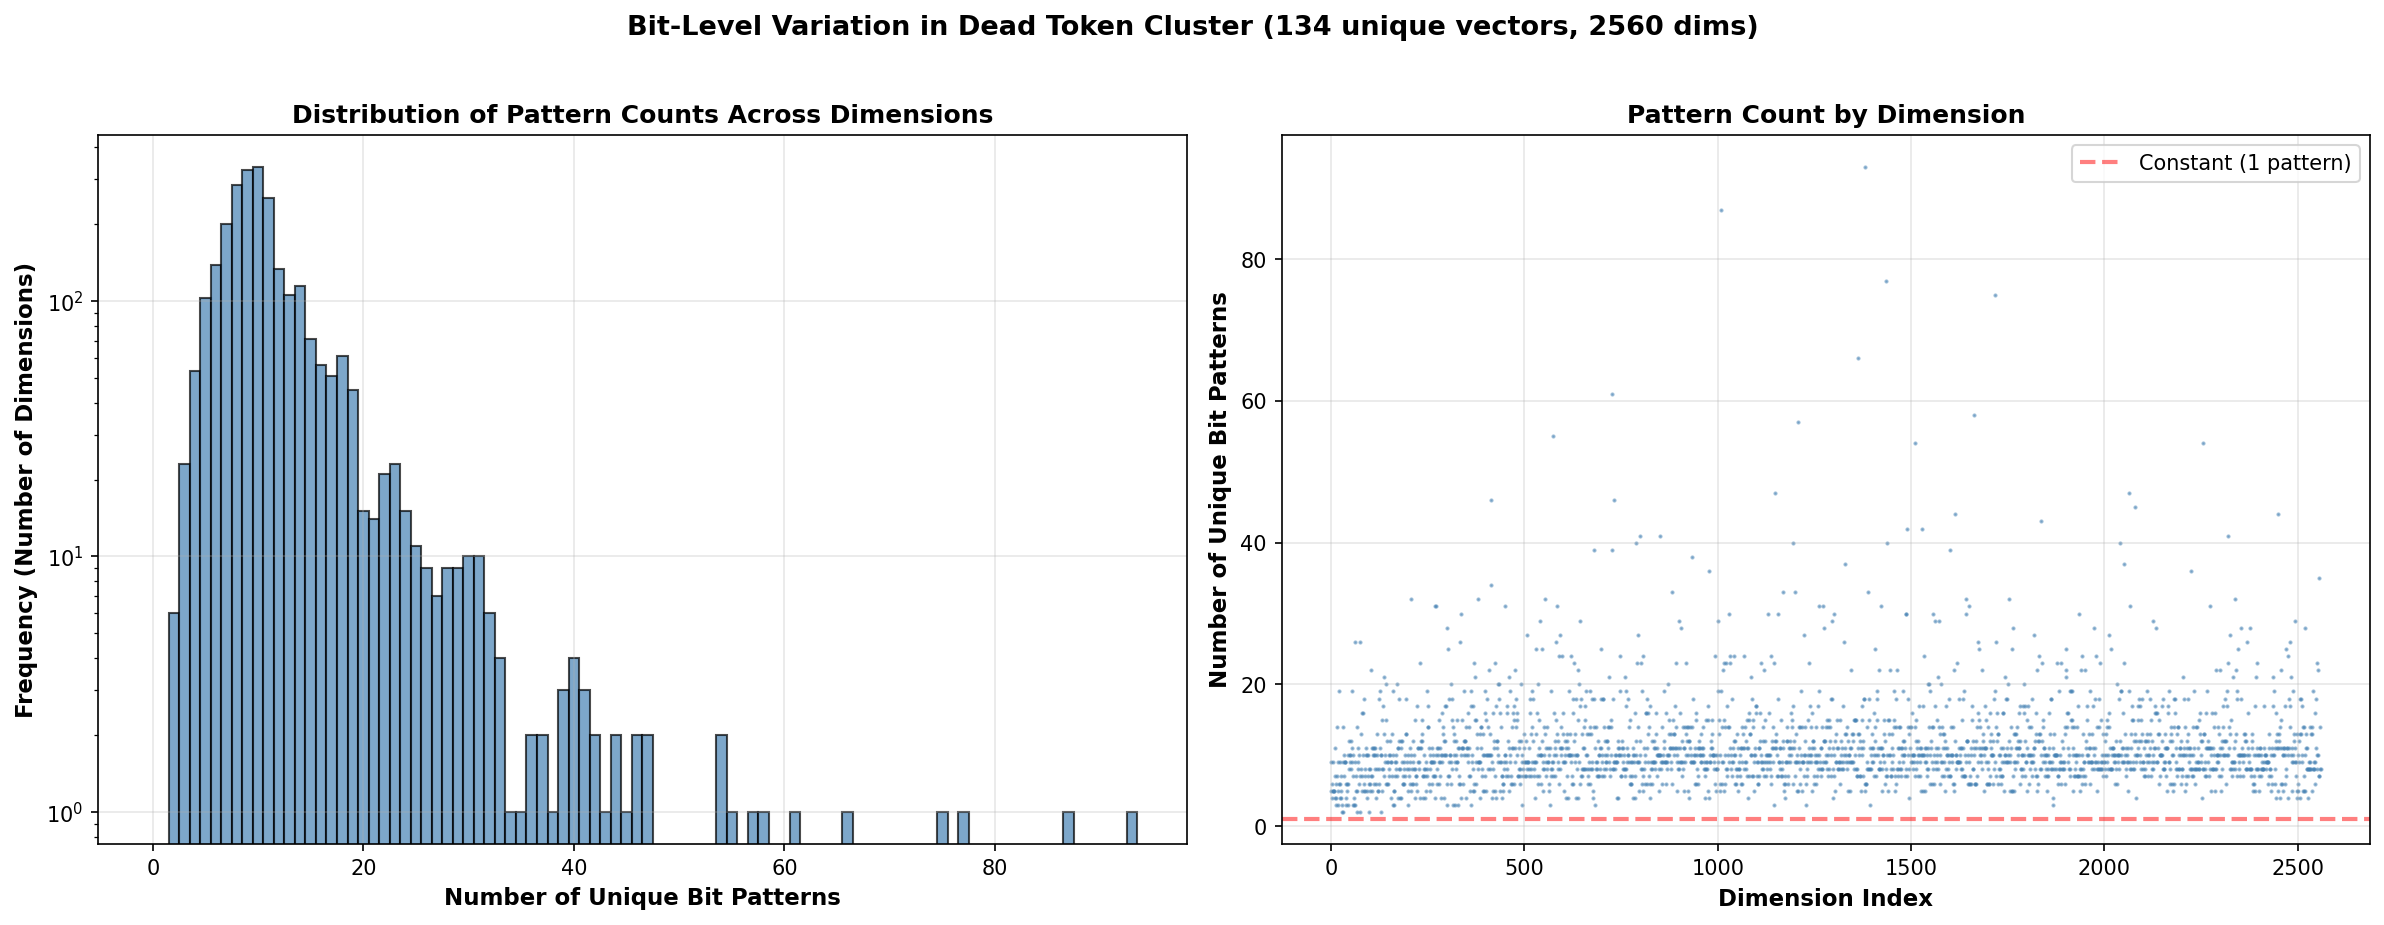

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

n_patterns_np = n_unique_patterns.cpu().numpy()

# Left: Histogram of unique pattern counts
ax = axes[0]
ax.hist(n_patterns_np, bins=np.arange(n_patterns_np.max() + 2) - 0.5, 
        color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of Unique Bit Patterns', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency (Number of Dimensions)', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Pattern Counts Across Dimensions', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Right: Scatter plot of pattern count by dimension index
ax = axes[1]
ax.scatter(np.arange(n_dims), n_patterns_np, s=1, alpha=0.5, color='steelblue')
ax.axhline(1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Constant (1 pattern)')
ax.set_xlabel('Dimension Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Unique Bit Patterns', fontsize=11, fontweight='bold')
ax.set_title('Pattern Count by Dimension', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Bit-Level Variation in Dead Token Cluster ({n_unique} unique vectors, {n_dims} dims)',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Figure 2: Bit Range Distribution

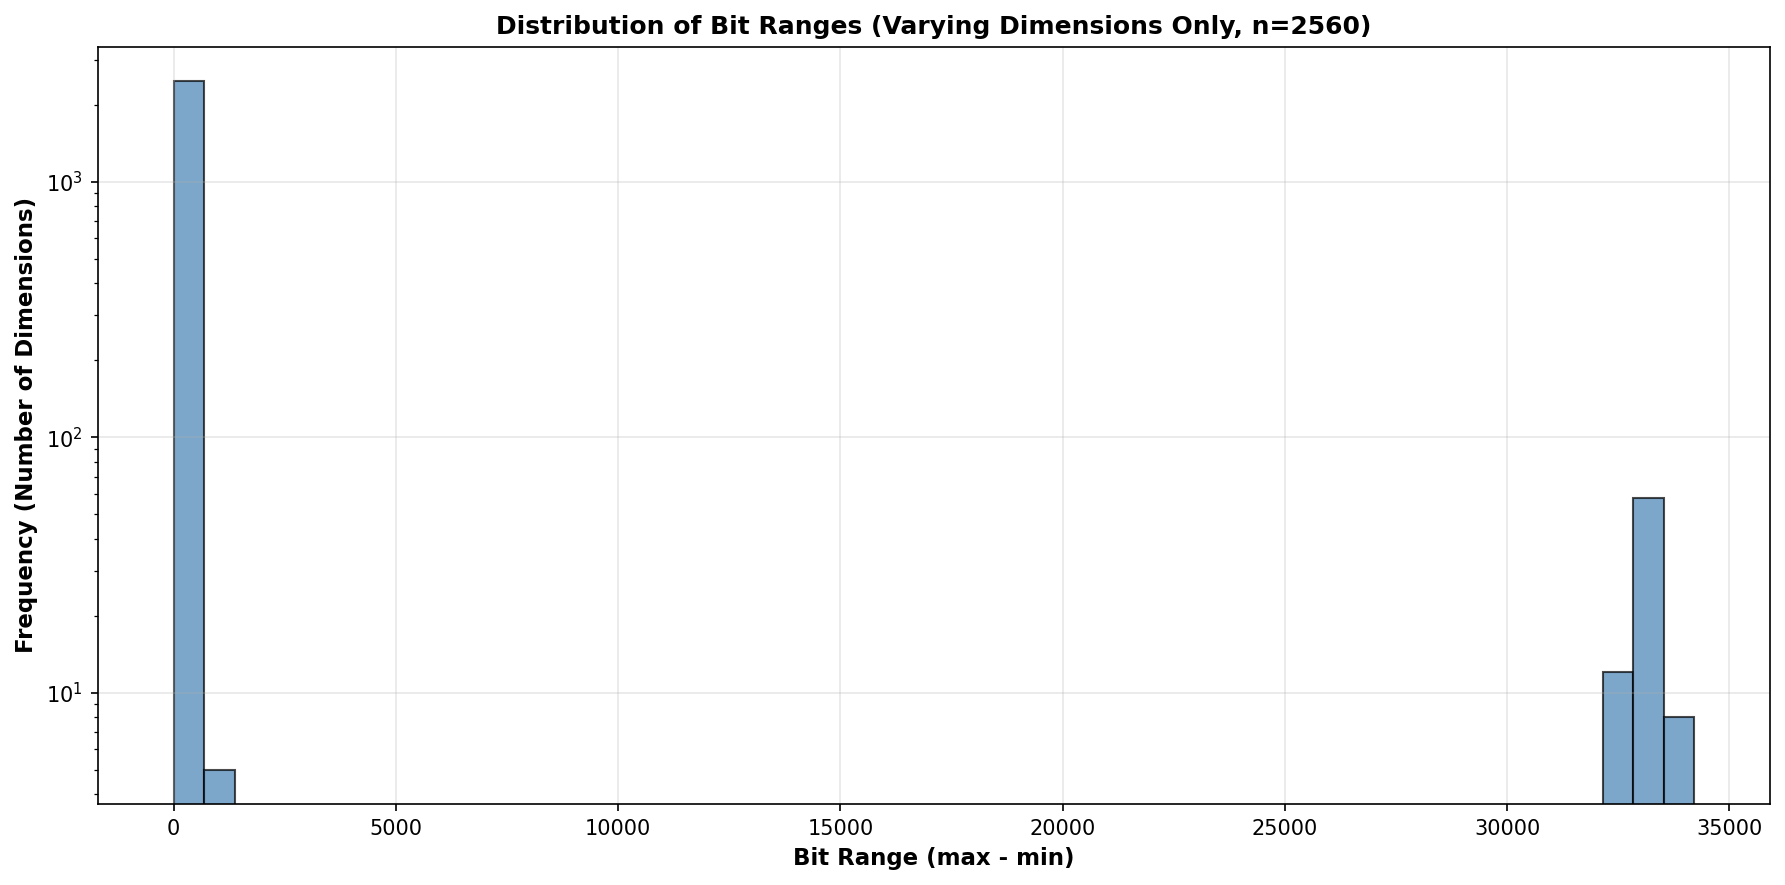

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=DPI)

bit_ranges_np = bit_ranges.cpu().numpy()

# Histogram of bit ranges
ax.hist(bit_ranges_np[bit_ranges_np > 0], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Bit Range (max - min)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency (Number of Dimensions)', fontsize=11, fontweight='bold')
ax.set_title(f'Distribution of Bit Ranges (Varying Dimensions Only, n={n_varying})', 
             fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Analysis: Example Varying Dimension

Pick one varying dimension and show all its bit patterns.

In [11]:
# Pick first varying dimension as example
example_dim = varying_dim_indices[0].item()

print(f"\nDetailed analysis of dimension {example_dim}:\n")

# Get all bit patterns in this dimension
values_in_dim = unique_as_bits[:, example_dim]
unique_patterns = torch.unique(values_in_dim, sorted=True)

print(f"Number of unique patterns: {len(unique_patterns)}")
print(f"\nAll bit patterns (as int16):")
for i, pattern in enumerate(unique_patterns):
    # Convert to binary representation
    pattern_int = pattern.item()
    # Handle negative numbers (two's complement)
    if pattern_int < 0:
        pattern_uint = pattern_int + 2**16
    else:
        pattern_uint = pattern_int
    
    binary = format(pattern_uint, '016b')
    sign = binary[0]
    exponent = binary[1:9]
    mantissa = binary[9:16]
    
    # Count how many unique vectors have this pattern
    n_vectors = (values_in_dim == pattern).sum().item()
    
    print(f"  {i+1:2d}. {pattern_int:6d} = 0b{binary} (s:{sign} e:{exponent} m:{mantissa}) [{n_vectors} vectors]")

# Show bit range
bit_range = unique_patterns[-1].item() - unique_patterns[0].item()
print(f"\nBit range: {bit_range}")


Detailed analysis of dimension 0:

Number of unique patterns: 9

All bit patterns (as int16):
   1.  15296 = 0b0011101111000000 (s:0 e:01110111 m:1000000) [2 vectors]
   2.  15300 = 0b0011101111000100 (s:0 e:01110111 m:1000100) [1 vectors]
   3.  15302 = 0b0011101111000110 (s:0 e:01110111 m:1000110) [2 vectors]
   4.  15303 = 0b0011101111000111 (s:0 e:01110111 m:1000111) [121 vectors]
   5.  15304 = 0b0011101111001000 (s:0 e:01110111 m:1001000) [4 vectors]
   6.  15305 = 0b0011101111001001 (s:0 e:01110111 m:1001001) [1 vectors]
   7.  15308 = 0b0011101111001100 (s:0 e:01110111 m:1001100) [1 vectors]
   8.  15309 = 0b0011101111001101 (s:0 e:01110111 m:1001101) [1 vectors]
   9.  15314 = 0b0011101111010010 (s:0 e:01110111 m:1010010) [1 vectors]

Bit range: 18


## Summary

In [12]:
print(f"\n{'='*80}")
print(f"BFLOAT16 BIT-LEVEL ANALYSIS SUMMARY")
print(f"{'='*80}")
print(f"\nDead token cluster: {n_unique} unique vectors in {n_dims} dimensions")
print(f"\nDimensional structure:")
print(f"  Constant dimensions: {n_constant} ({n_constant/n_dims*100:.1f}%)")
print(f"  Varying dimensions: {n_varying} ({n_varying/n_dims*100:.1f}%)")
print(f"\nBit-level variation (varying dims only):")
print(f"  Min bit range: {varying_ranges.min().item()}")
print(f"  Max bit range: {varying_ranges.max().item()}")
print(f"  Mean bit range: {varying_ranges.float().mean().item():.2f}")

# Check if this is a hypercube
if varying_ranges.max().item() <= 2:
    print(f"\n→ Structure consistent with 2^k hypercube (all ranges ≤ 2)")
    print(f"   The {n_unique} unique vectors occupy vertices of a hypercube in bfloat16 space")
else:
    print(f"\n→ Structure more complex than simple hypercube (some ranges > 2)")

print(f"\n{'='*80}")


BFLOAT16 BIT-LEVEL ANALYSIS SUMMARY

Dead token cluster: 134 unique vectors in 2560 dimensions

Dimensional structure:
  Constant dimensions: 0 (0.0%)
  Varying dimensions: 2560 (100.0%)

Bit-level variation (varying dims only):
  Min bit range: 1
  Max bit range: 34202
  Mean bit range: 1050.50

→ Structure more complex than simple hypercube (some ranges > 2)

